<a href="https://colab.research.google.com/github/codingCat06/CNN_Cat-Dog/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import torch
from torch import nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

dataset_dir = "./dataset/train"
dataset_files = os.listdir(dataset_dir)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256 * 4 * 4, 128),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,2),
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [102]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


class CatDog_Dataset(Dataset):
    def __init__(self, file_list, dir_path, data_type="train"):
        self.file_list = file_list
        self.transformation = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],    # 각 채널별 정규화 (R,G,B)
                         std=[0.5, 0.5, 0.5])
        ])
        self.dir_path = dir_path
        self.data_type = data_type

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.dir_path, file_name)
        image = self.transformation(Image.open(file_path))
        label = 0 if "cat" in file_name.lower() else 1  # 훈련용 fallback

        return image, label

In [103]:
dataset = CatDog_Dataset(dataset_files, dataset_dir)
train_size = int(len(dataset)*0.7)
test_size = len(dataset) - train_size
train, validation = random_split(dataset,[train_size, test_size])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [104]:
train_dataset = DataLoader(train, batch_size=64, shuffle=True)
val_dataset = DataLoader(validation, batch_size=64, shuffle=False)

In [105]:
samples, labels = next(iter(train_dataset))
print(labels)

print(f"Shape: {samples.shape}")
print(f"Dtype: {samples.dtype}")
print(f"Device: {samples.device}")
print(f"Max: {samples.max()}, Min: {samples.min()}")

tensor([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])
Shape: torch.Size([64, 3, 128, 128])
Dtype: torch.float32
Device: cpu
Max: 1.0, Min: -1.0


In [106]:
samples, labels = next(iter(val_dataset))
print(labels)

print(f"Shape: {samples.shape}")
print(f"Dtype: {samples.dtype}")
print(f"Device: {samples.device}")
print(f"Max: {samples.max()}, Min: {samples.min()}")

tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0])
Shape: torch.Size([64, 3, 128, 128])
Dtype: torch.float32
Device: cpu
Max: 1.0, Min: -1.0


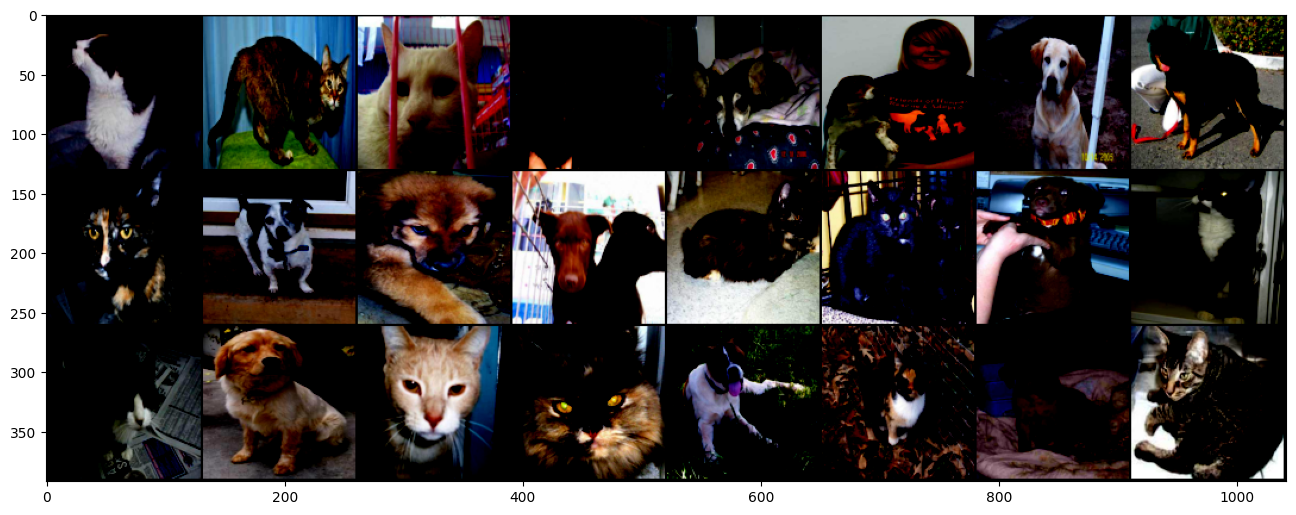

In [107]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [108]:
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
           Dropout-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

In [109]:
from tqdm import tqdm
import torch

train_loss = []
train_accuracy = []

validation_loss = []
validation_accuracy = []

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch [{epoch+1}/{epochs}]")
    progress_bar = tqdm(train_dataset, desc="Training", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        current_loss = running_loss / (total / labels.size(0))
        current_acc = correct / total
        progress_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct / total
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


    print("\nValidating...")



    val_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        val_bar = tqdm(val_dataset, desc="Validation", leave=False)
        for images, labels in val_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_acc_so_far = val_correct / total
            val_bar.set_postfix(acc=f"{val_acc_so_far:.4f}")

    val_accuracy = val_correct / total
    validation_accuracy.append(val_accuracy)
    print(f"\nFinal Validation Accuracy: {val_accuracy:.4f}")



Epoch [1/10]


Epoch [1/10] - Loss: 0.6708, Accuracy: 0.5739

Validating...



Final Validation Accuracy: 0.6295

Epoch [2/10]


Epoch [2/10] - Loss: 0.6026, Accuracy: 0.6675

Validating...



Final Validation Accuracy: 0.7113

Epoch [3/10]


Epoch [3/10] - Loss: 0.5462, Accuracy: 0.7218

Validating...



Final Validation Accuracy: 0.7473

Epoch [4/10]


Epoch [4/10] - Loss: 0.4985, Accuracy: 0.7555

Validating...



Final Validation Accuracy: 0.7680

Epoch [5/10]


Epoch [5/10] - Loss: 0.4721, Accuracy: 0.7749

Validating...



Final Validation Accuracy: 0.7900

Epoch [6/10]


Epoch [6/10] - Loss: 0.4372, Accuracy: 0.7989

Validating...



Final Validation Accuracy: 0.8104

Epoch [7/10]


Epoch [7/10] - Loss: 0.4104, Accuracy: 0.8093

Validating...



Final Validation Accuracy: 0.8187

Epoch [8/10]


Epoch [8/10] - Loss: 0.3839, Accuracy: 0.8245

Validating...



Final Validation Accuracy: 0.8187

Epoch [9/10]


Epoch [9/10] - Loss: 0.3516, Accuracy: 0.8415

Validating...



Final Validation Accuracy: 0.8407

Epoch [10/10]


Epoch [10/10] - Loss: 0.3281, Accuracy: 0.8509

Validating...



Final Validation Accuracy: 0.8429


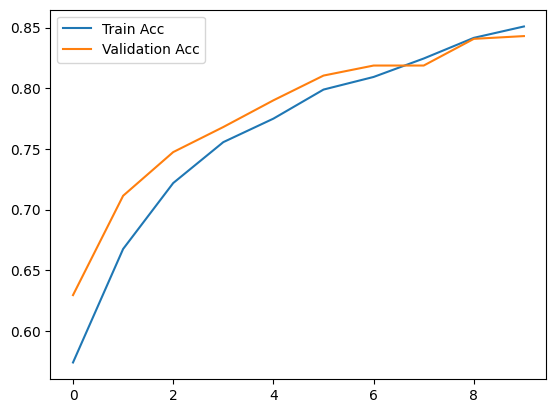

In [110]:
plt.plot(train_accuracy, label='Train Acc')
plt.plot(validation_accuracy, label='Validation Acc')

plt.legend()
plt.show()
